In [1]:
import scipy.io
import pandas as pd
from elephant.gpfa import GPFA
import numpy as np
import quantities as pq
import neo
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)


## Load Data

In [2]:
## load spikeTime data as neo.spiketrains
with open('data/spikeTimes.pickle', 'rb') as filename:
    st = pickle.load(filename)
    
## load behavior data
behav = pd.read_csv('data/RT_cue_choice.csv',header=None, names=['RT','cue','choice'])
# add a movement onset column
behav['mvmt'] = behav['RT'] + 400

## load latent dynamics from elephant.gpfa with 4 dims
with open('data/gpfa_trajectories_4d.pickle', 'rb') as filename:
    trajectories_all = pickle.load(filename)

In [3]:
behav.head()
# choice: green - right - 2
# choice: red   - left  - 1

,RT,cue,choice,mvmt
0,297,67,1,697
1,309,117,1,709
2,313,214,1,713
3,316,108,1,716
4,322,180,1,722


In [4]:
# number of trials and neurons
numTrials = len(st)
numNeurons = len(st[0])

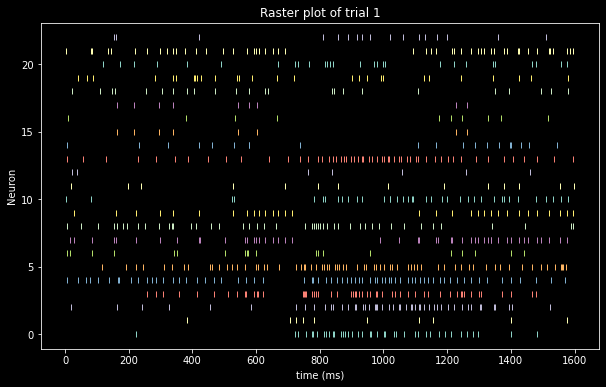

In [5]:
# raster plot

fig = plt.figure(figsize=(10,6))
for i, spiketrain in enumerate(st[0]):
    plt.plot(spiketrain, np.ones_like(spiketrain)*i, ls='', marker='|')

plt.title('Raster plot of trial 1')
plt.xlabel('time (ms)')
plt.ylabel('Neuron')
# plt.savefig('images/gpfa_data_raster.png')
plt.show()

## Apply GPFA

In [6]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 4

gpfa = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [7]:
# apply GPFA
# trajectories_all = gpfa.fit_transform(st)

## Analysis and Plots

In [8]:
# function to make plots look cleaner
def transBackground(ax, dim):
    if dim==3:
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        ax.grid(False)
    if dim==2:
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.grid(False)

# function to get index of times vector where movement onset occurs
def mvmtIdx(trial_idx):
    m = behav['mvmt'][trial_idx]
    m = np.floor(m)
    for i in range(20):
        if m % 20 == 0:
            break
        m += 1
    try:
        t_idx = np.where(times==m)[0][0]
    except:
        t_idx = len(times)
    return t_idx

# function that returns index of times vector, provided RT as index
def RT_idx(m):
    m = np.floor(m)
    for i in range(20):
        if m % 20 == 0:
            break
        m += 1
    try:
        t_idx = np.where(times==m)[0][0]
    except:
        t_idx = len(times)
    return t_idx

In [9]:
# generate a time vector compatible with neo.spiketrains
times = np.arange(len(trajectories_all[0][0])) * bin_size.rescale('ms')

# checkerboard onset idx
checkOnIdx = np.where(times==400)[0][0]

### Visualize GPFA Latent Dynamics

In [10]:
# generate random trial vector for plotting ax1
ct = 500 # number of trials to plot
possible = np.arange(1877)
np.random.shuffle(possible)
picks = possible[:ct]

In [11]:
# get average trajectories for left and right reaches
right_trials = behav[behav['choice']==2] # green
left_trials = behav[behav['choice']==1]   # red
right_trials_idx = list(right_trials.index)
left_trials_idx = list(left_trials.index)
r_traj = trajectories_all[right_trials_idx]
l_traj = trajectories_all[left_trials_idx]
r_avg_traj = np.mean(r_traj, axis=0)
l_avg_traj = np.mean(l_traj, axis=0)

# get times index for when reach happens for averaged trials
r_avg_mvmt_idx = RT_idx(np.mean(right_trials['mvmt']))
l_avg_mvmt_idx = RT_idx(np.mean(left_trials['mvmt']))

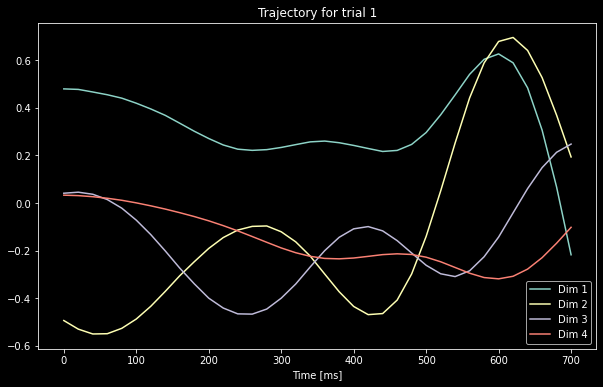

In [12]:
## plot a single trial's trajectories until movement onset
f = plt.figure(figsize=(10, 6))
ax2 = f.add_subplot(1, 1, 1)

trial_to_plot = 1
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [ms]')
# get mvmt onset index
t_idx = mvmtIdx(trial_to_plot)
ax2.plot(times[:t_idx], trajectories_all[0][0][:t_idx], c='C0', label="Dim 1")
ax2.plot(times[:t_idx], trajectories_all[0][1][:t_idx], c='C1', label="Dim 2")
ax2.plot(times[:t_idx], trajectories_all[0][2][:t_idx], c='C2', label="Dim 3")
ax2.plot(times[:t_idx], trajectories_all[0][3][:t_idx], c='C3', label="Dim 4")
ax2.legend(loc='best')

# plt.savefig('images_for_pres/trial1_traj.png',dpi=300)
plt.show()

In [13]:
# %matplotlib notebook

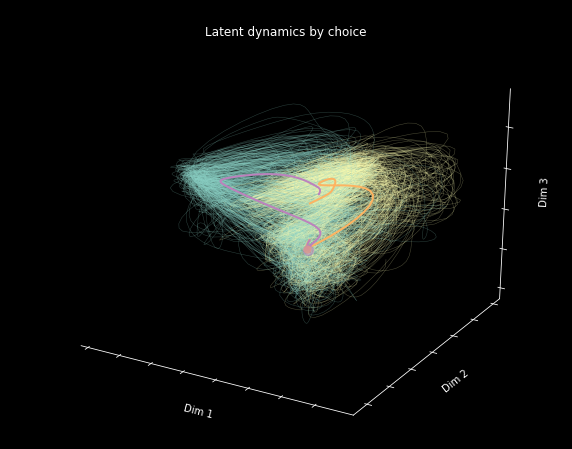

In [14]:
## plot setup

f = plt.figure(figsize=(10, 8))
ax1 = f.add_subplot(1, 1, 1, projection='3d')

## plot GPFA latent dynamics by choice

ax1.set_title('Latent dynamics by choice')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_zlabel('Dim 3')
        
for pick in picks:
    trial = trajectories_all[pick]
    if behav['choice'][pick] == 1:
        # left reaches
        ax1.plot(trial[0], trial[1], trial[2], '-', lw=0.5, c='C0', alpha=0.3)
    else:
        # reach reaches
        ax1.plot(trial[0], trial[1], trial[2], '-', lw=0.5, c='C1', alpha=0.3)

# avg right reaches (green dot)
ax1.plot(r_avg_traj[0], r_avg_traj[1], r_avg_traj[2], '-', lw=2, c='C5')
ax1.scatter(r_avg_traj[0][checkOnIdx], r_avg_traj[1][checkOnIdx], r_avg_traj[2][checkOnIdx], s=50, c='C5', alpha=0.8)
# ax1.scatter(r_avg_traj[0][r_avg_mvmt_idx], r_avg_traj[1][r_avg_mvmt_idx], r_avg_traj[2][r_avg_mvmt_idx], s=50, c='C5', alpha=0.8)

# avg left reaches
ax1.plot(l_avg_traj[0], l_avg_traj[1], l_avg_traj[2], '-', lw=2, c='C7')
ax1.scatter(l_avg_traj[0][checkOnIdx], l_avg_traj[1][checkOnIdx], l_avg_traj[2][checkOnIdx], s=100, c='C7', alpha=0.5)
# ax1.scatter(r_avg_traj[0][l_avg_mvmt_idx], r_avg_traj[1][l_avg_mvmt_idx], r_avg_traj[2][l_avg_mvmt_idx], s=100, c='C3', alpha=0.8)
transBackground(ax1,3)
# ax1.legend(['right(red)','left(green)','avg'])

# plt.savefig('images_for_pres/LD_all_t.png',dpi=300)
plt.show()

### Plot latent dynamics of specific cue trials by fast and slow reaches

In [15]:
# get trials by cue == {214, 180} and then use those trials for plots in this section (3.2)
# reduce fast and slow trials to those with cues of 
cue214 = behav[behav['cue']==214]
cue180 = behav[behav['cue']==180]
cueBehav = pd.concat([cue214, cue180])

In [16]:
# get fast and slow reach trials
quantiles = cueBehav['RT'].quantile([0.25,0.75])
fast_RT_trials = cueBehav[cueBehav['RT'] <= quantiles[0.25]]
slow_RT_trials = cueBehav[cueBehav['RT'] >= quantiles[0.75]]
fastRTidx = list(fast_RT_trials.index)
slowRTidx = list(slow_RT_trials.index)

In [17]:
# separate fast and slow trials by choice
fast_left = fast_RT_trials[fast_RT_trials['choice']==1]
fast_right = fast_RT_trials[fast_RT_trials['choice']==2]
slow_left = slow_RT_trials[slow_RT_trials['choice']==1]
slow_right = slow_RT_trials[slow_RT_trials['choice']==2]

fl_idx = list(fast_left.index)
fr_idx = list(fast_right.index)
sl_idx = list(slow_left.index)
sr_idx = list(slow_right.index)

fl_traj = trajectories_all[fl_idx]
fr_traj = trajectories_all[fr_idx]
sl_traj = trajectories_all[sl_idx]
sr_traj = trajectories_all[sr_idx]

In [18]:
# average trajectoroes for fl, fr, sl, sr
fl_avg = np.mean(fl_traj, axis=0)
fr_avg = np.mean(fr_traj, axis=0)
sl_avg = np.mean(sl_traj, axis=0)
sr_avg = np.mean(sr_traj, axis=0)

# avg time to mvmt onset
fl_avg_idx = RT_idx(np.mean(behav['mvmt'][fl_idx]))
fr_avg_idx = RT_idx(np.mean(behav['mvmt'][fr_idx]))
sl_avg_idx = RT_idx(np.mean(behav['mvmt'][sl_idx]))
sr_avg_idx = RT_idx(np.mean(behav['mvmt'][sr_idx]))

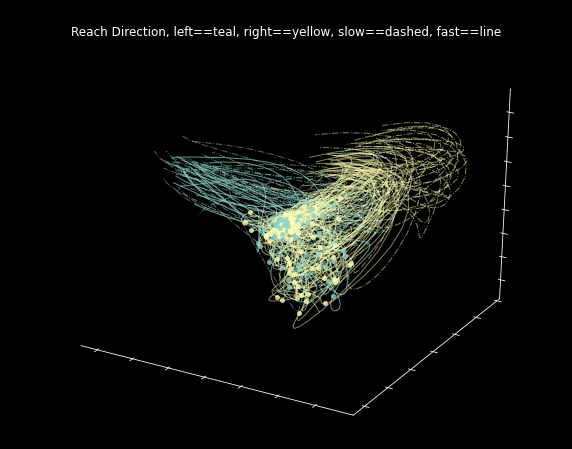

In [19]:
##  plot setup

f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(1, 1, 1, projection='3d')

## ax1 - plot by reach direction

ax1.set_title('Reach Direction, left==teal, right==yellow, slow==dashed, fast==line')

# plot fast left
ct = 0
for traj in fl_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(fl_idx[ct])
    # plot
    ax1.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C0', alpha=0.7)
    ax1.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C0', alpha=0.8)
    ct += 1
    
# plot slow left
ct = 0
for traj in sl_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(sl_idx[ct])
    # plot
    ax1.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-.', lw=1, c='C0', alpha=0.5)
    ax1.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C0', alpha=0.8)
    ct += 1
    
# plot fast right
ct = 0
for traj in fr_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(fr_idx[ct])
    # plot
    ax1.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C1', alpha=0.5)
    ax1.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C1', alpha=0.8)
    ct += 1

# plot slow right
ct = 0
for traj in sr_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(sr_idx[ct])
    # plot
    ax1.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-.', lw=1, c='C1', alpha=0.5)
    ax1.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C1', alpha=0.8)
    ct += 1

transBackground(ax1,3)
# plt.savefig('images_for_pres/LD_by_RD.png',dpi=300)
plt.show()

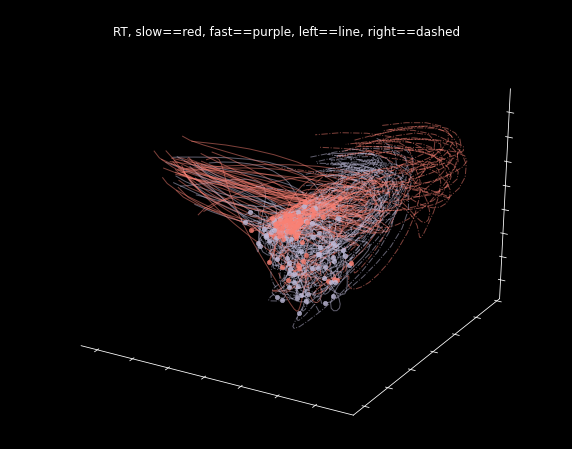

In [20]:
##  plot setup

f = plt.figure(figsize=(10,8))
ax2 = f.add_subplot(1,1,1, projection='3d')

## ax2 - plot by RT

ax2.set_title('RT, slow==red, fast==purple, left==line, right==dashed')

# plot fast left
ct = 0
for traj in fl_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(fl_idx[ct])
    # plot
    ax2.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C2', alpha=0.5)
    ax2.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C2', alpha=0.8)
    ct += 1
    
# plot slow left
ct = 0
for traj in sl_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(sl_idx[ct])
    # plot
    ax2.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C3', alpha=0.5)
    ax2.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C3', alpha=0.8)
    ct += 1
    
# plot fast right
ct = 0
for traj in fr_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(fr_idx[ct])
    # plot
    ax2.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-.', lw=1, c='C2', alpha=0.5)
    ax2.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C2', alpha=0.8)
    ct += 1

# plot slow right
ct = 0
for traj in sr_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(sr_idx[ct])
    # plot
    ax2.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-.', lw=1, c='C3', alpha=0.5)
    ax2.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C3', alpha=0.8)
    ct += 1

transBackground(ax2,3)
# plt.savefig('images_for_pres/LD_by_RT.png',dpi=300)
plt.show()

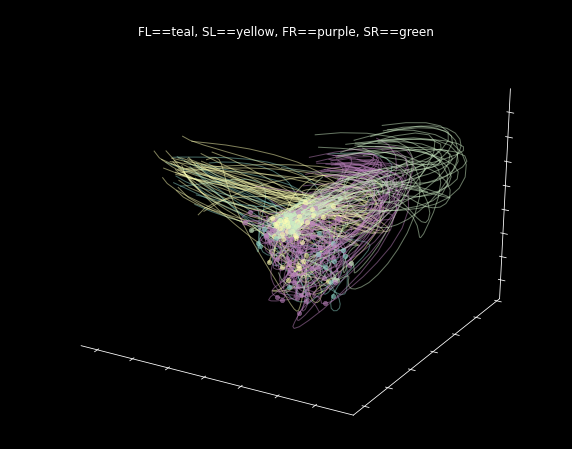

In [21]:
##  plot setup

f = plt.figure(figsize=(10,8))
ax3 = f.add_subplot(1, 1, 1, projection='3d')

## ax3 - plot by RT and reach direction

ax3.set_title('FL==teal, SL==yellow, FR==purple, SR==green')

# plot fast left
ct = 0
for traj in fl_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(fl_idx[ct])
    # plot
    ax3.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C0', alpha=0.5)
    ax3.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C0', alpha=0.6)
    ct += 1
    
# plot slow left
ct = 0
for traj in sl_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(sl_idx[ct])
    # plot
    ax3.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C1', alpha=0.5)
    ax3.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C1', alpha=0.6)
    ct += 1
    
# plot fast right
ct = 0
for traj in fr_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(fr_idx[ct])
    # plot
    ax3.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C7', alpha=0.5)
    ax3.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C7', alpha=0.6)
    ct += 1

# plot slow right
ct = 0
for traj in sr_traj:
    # get mvmt onset index
    t_idx = mvmtIdx(sr_idx[ct])
    # plot
    ax3.plot(traj[0][:t_idx],traj[1][:t_idx],traj[2][:t_idx],'-', lw=1, c='C8', alpha=0.5)
    ax3.scatter(traj[0][checkOnIdx],traj[1][checkOnIdx],traj[2][checkOnIdx], lw=0.5, c='C8', alpha=0.6)
    ct += 1

transBackground(ax3,3)
# plt.savefig('images_for_pres/LD_by_RD_RT.png',dpi=300)
plt.show()

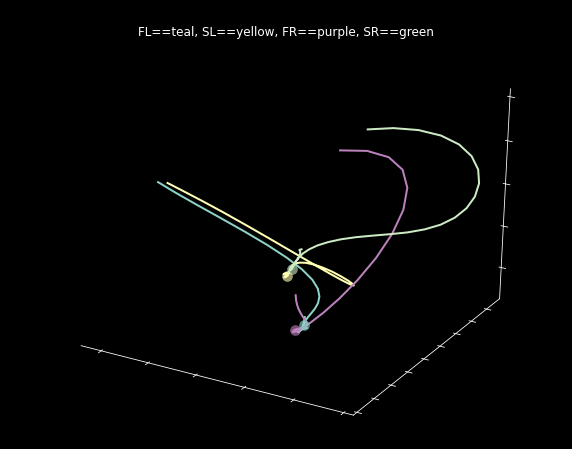

In [22]:
##  plot setup

f = plt.figure(figsize=(10,8))
ax4 = f.add_subplot(1, 1, 1, projection='3d')

## ax4 - plot ax3 but averaged trajectories

ax4.set_title('FL==teal, SL==yellow, FR==purple, SR==green')

# plot fast left
ax4.plot(fl_avg[0][:fl_avg_idx],fl_avg[1][:fl_avg_idx],fl_avg[2][:fl_avg_idx],'-', lw=2, c='C0', alpha=1)
ax4.scatter(fl_avg[0][checkOnIdx],fl_avg[1][checkOnIdx],fl_avg[2][checkOnIdx], s=100, lw=0.5, c='C0', alpha=0.6)
    
# plot slow left
ax4.plot(sl_avg[0][:sl_avg_idx],sl_avg[1][:sl_avg_idx],sl_avg[2][:sl_avg_idx],'-', lw=2, c='C1', alpha=1)
ax4.scatter(sl_avg[0][checkOnIdx],sl_avg[1][checkOnIdx],sl_avg[2][checkOnIdx], s=100, lw=0.5, c='C1', alpha=0.6)
    
# plot fast right
ax4.plot(fr_avg[0][:fr_avg_idx],fr_avg[1][:fr_avg_idx],fr_avg[2][:fr_avg_idx],'-', lw=2, c='C7', alpha=1)
ax4.scatter(fr_avg[0][checkOnIdx],fr_avg[1][checkOnIdx],fr_avg[2][checkOnIdx], s=100, lw=0.5, c='C7', alpha=0.6)

# plot slow right
ax4.plot(sr_avg[0][:sr_avg_idx],sr_avg[1][:sr_avg_idx],sr_avg[2][:sr_avg_idx],'-', lw=2, c='C8', alpha=1)
ax4.scatter(sr_avg[0][checkOnIdx],sr_avg[1][checkOnIdx],sr_avg[2][checkOnIdx], s=100, lw=0.5, c='C8', alpha=0.6)

transBackground(ax4,3)
# plt.savefig('images_for_pres/LD_by_RD_RT_avg.png',dpi=300)
plt.show()

### Plot latent dynamics binned by RT

In [23]:
# define RT bins
RT_bins = {}
ct = 0
for i in range(min(behav['RT']), max(behav['RT']), 100):
    RT_bins[ct] = [i,i+100]
    ct += 1
    
# get trials for each bin
binned_trials = {}
for i, binArray in RT_bins.items():
    binned_trials[i] = behav[(behav['RT'] >= binArray[0]) & (behav['RT'] < binArray[1])]
    
# delete empty bins
del binned_trials[10]
del RT_bins[10]

# get mvmt idx for each of the averaged trajectories
mvmtIdx = {}
for i, trials in binned_trials.items():
    mvmtIdx[i] = RT_idx(np.mean(trials['mvmt']))
    if mvmtIdx[i] > 57:
        mvmtIdx[i] = 57

# get left and right trials for each bin
temp = {}
for i, trials in binned_trials.items():
    temp[i] = {}
    temp[i]['left'] = binned_trials[i][binned_trials[i]['choice']==1]
    temp[i]['right'] = binned_trials[i][binned_trials[i]['choice']==2]
binned_trials = temp

# delete empty bins
del binned_trials[11]['left']

# average the binned trials
avg_traj = {}
for i in binned_trials.keys():
    avg_traj[i] = {}
    for dir in binned_trials[i].keys():
        trials = binned_trials[i][dir]
        idx = list(trials.index)
        traj = trajectories_all[idx]
        avg_traj[i][dir] = np.mean(traj, axis=0)
            


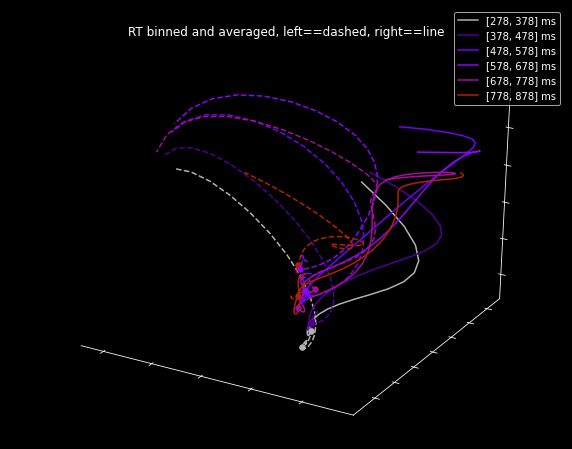

In [33]:
##  plot setup

f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(1, 1, 1, projection='3d')

## ax1 - RT-binned and averaged trajectories

ax1.set_title('RT binned and averaged, left==dashed, right==line')

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(avg_traj.keys()))]
colors[0] = [0.7,0.7,0.7,1]

# average the binned trials
ct = 0
for i in avg_traj.keys():
    for dir in avg_traj[i].keys():
        traj = avg_traj[i][dir]
        if dir=='right':
            ax1.plot(traj[0][:mvmtIdx[i]], traj[1][:mvmtIdx[i]], traj[3][:mvmtIdx[i]],'-', c=colors[ct], label=str(RT_bins[i]) + ' ms')
            ax1.scatter(traj[0][checkOnIdx], traj[1][checkOnIdx], traj[3][checkOnIdx], s=30, c=np.array(colors[ct][:3]).reshape(1,3))
        else:
            ax1.plot(traj[0][:mvmtIdx[i]], traj[1][:mvmtIdx[i]], traj[3][:mvmtIdx[i]],'--', c=colors[ct])
            ax1.scatter(traj[0][checkOnIdx], traj[1][checkOnIdx], traj[3][checkOnIdx], s=30, c=np.array(colors[ct][:3]).reshape(1,3))
    ct += 1
    if i==5:
        break

transBackground(ax1,3)
# ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.legend(loc='best')
# plt.savefig('images_for_pres/LD_RT_binned.png',dpi=300)
plt.show()

## Linear Regression - Reaction Time vs Neural State

In [25]:
# define X, each row of X is consists of 4 values (1 value for each dimension)
# each column of X consists of 80 
# X_dict[time pt][trial num , dim], time pt from 1:80, trial num from 1:1877, dim from 1:4

X_dict = {}
for t in range(len(times)):
    X_dict[t] = np.empty([len(trajectories_all),4])
    for i in range(len(trajectories_all)):
        cur_traj = trajectories_all[i]
        X_dict[t][i,:] = cur_traj[:,t]

# define y, reaction time
y = np.array(behav['RT'])

In [26]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, test_size=0.33, random_state=42)

X_train = {}
X_test = {}

for t in range(len(times)):
    X_train[t], X_test[t] = train_test_split(X_dict[t], test_size=0.33, random_state=42)

In [27]:
# fit a linear regression line for each trial via:
# y = C * X, where y is reaction time, c is coefficient matrix, and X is data matrix

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train and test the model using the training sets
r_squared = []
for t in range(len(times)):
    fit = regr.fit(X_train[t], y_train)
    predict = regr.predict(X_test[t])
    r_squared.append(regr.score(X_test[t],y_test))

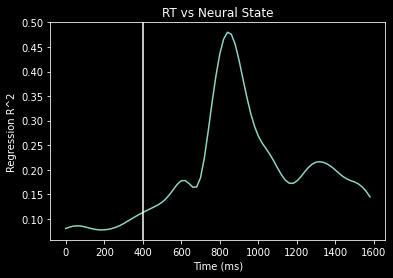

In [28]:
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(1,1,1)
ax.set_title('RT vs Neural State')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Regression R^2')
ax.plot(times, r_squared)
ax.axvline(400)
# plt.savefig('images_for_pres/RT_vs_Neural_State.png',dpi=300)
plt.show()

## Classification - Choice Decoder

In [29]:
# define data, X, and labels, y

X_dict = X_dict # X remains the same as in linear regression
y = np.array(behav['choice'])

In [30]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, test_size=0.33, random_state=42)

X_train = {}
X_test = {}

for t in range(len(times)):
    X_train[t], X_test[t] = train_test_split(X_dict[t], test_size=0.33, random_state=42)

In [31]:
# classification

from sklearn.linear_model import SGDClassifier

# Train and test the model using the training sets
acc = []
for t in range(len(times)):
    clf = SGDClassifier(loss="hinge", penalty="l2", tol=1e-5)
    clf.fit(X_train[t], y_train)
    acc.append(clf.score(X_test[t],y_test))

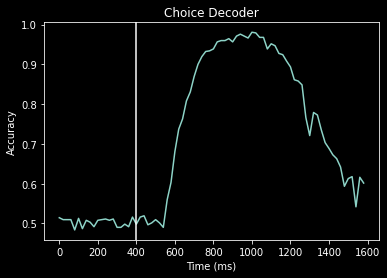

In [32]:
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(1,1,1)
ax.set_title('Choice Decoder')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Accuracy')
ax.plot(times, acc)
ax.axvline(400)
# plt.savefig('images_for_pres/Choice_Decoder.png',dpi=300)
plt.show()